In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import xarray as xr

In [2]:
def get_dbhydro(period='1week', dbkey='IX837/IX845/IX847',):
    '''
    period: options are  'year', 'month', '1week', '3day', 'today', 
                        'uspec&v_start_date=YYYYMMDD&v_end_date=YYYYMMDD'

    dbkey: dbhydro code for var/station. to get other coces see link on dbkeys
    ________________________________________________________
                        
    documentation : pages 87-89 https://www.sfwmd.gov/sites/default/files/dbhydro_browser_user_documentation.pdf
    
    dbkeys: https://my.sfwmd.gov/dbhydroplsql/show_dbkey_info.show_dbkeys_matched?v_station=L001&v_js_flag=N
    ________________________________________________________
    '''
    
    link = [
        "http://my.sfwmd.gov/dbhydroplsql/web_io.report_process?"+
        "v_period=%s&" % period+
        "v_report_type=format6&"+
        "v_target_code=file_csv&"+
        "v_run_mode=onLine&v_js_flag=Y&"+
        "v_dbkey=%s" % dbkey
    ]
    print(link)
    skip = len(dbkey.split('/'))+2

    df = pd.read_csv(link[0], skiprows=skip, 
                     names = ['Date', 'DBKEY', 'Val'], 
                     usecols=[0,2,3,],
                     parse_dates=['Date']
            )
    var_key = {
            'IX837': 'Air Temp [ºC]',
            'IX845': 'Rain [in]',
            'IX847': 'Wind speed [mph]',
            }
    df.replace({'DBKEY': var_key}, inplace=True)
    
    frames = []
    for name in df['DBKEY'].unique():
        sub = df.loc[df['DBKEY']==name].rename(columns={'Val': name}).set_index('Date')
        sub = sub.loc[~sub.index.duplicated(keep='first')]
        frames.append(sub.drop(columns='DBKEY'))
    
    return pd.concat(frames, axis=1)

In [4]:
# path = 'L001.csv'
# skip=11
# df = pd.read_csv(path, skiprows=skip, 
#                  names = ['Date', 'DBKEY', 'Val'], 
#                  usecols=[0,2,3,],
# #                  index_col=[0],
#                  parse_dates=['Date']
#         )
df = get_dbhydro(period='1week')
df

['http://my.sfwmd.gov/dbhydroplsql/web_io.report_process?v_period=1week&v_report_type=format6&v_target_code=file_csv&v_run_mode=onLine&v_js_flag=Y&v_dbkey=IX837/IX845/IX847']


ValueError: No objects to concatenate

In [53]:
var_key = {
            'IX837':{'name':'AIRT', 'units': 'Degrees Celsius'},
            'IX841':{'name':'HUMI', 'units': 'Percent'},
            'IX843':{'name':'RADP', 'units': 'MICROMOLE/m^2/s'},
            'IX844':{'name':'RADT', 'units': 'kW/m^2'},
            'IX845':{'name':'RAIN', 'units': 'Inches'},
            'IX846':{'name':'STG', 'units': 't NGVD29'},
            'IX847':{'name':'WNDS', 'units': 'MPH'},
            'J0942':{'name':'BARO', 'units': 'mm Mercury'},
            'KV264':{'name':'WNVD', 'units': 'DEGREES CLOCKWI'},
            }
# frames = {}
# for k_name in keys:
#     name = var_key[k_name]['name']
#     data = df.loc[df['DBKEY']==k_name].drop(columns='DBKEY').rename(columns={'Val': name}).set_index('Date')
#     frames[name] = data
    
# # ndf = pd.DataFrame(frames)
# # ndf
# U= table_dic['WS']['Val']*np.cos(table_dic['WD']['Val']*np.pi/180+.5*np.pi)
# V= - table_dic['WS']['Val']*np.sin(table_dic['WD']['Val']*np.pi/180+.5*np.pi)
# wdf = pd.DataFrame({'U':U,
#                     'V':V, 
#                     'S': table_dic['WS']['Val']}
#                   )
# wdf

ds = xr.open_dataset('forecast.nc')
ds['Wind speed [mph]'] = np.sqrt(ds['UGRD_10maboveground']**2 + ds['VGRD_10maboveground']**2)*(3600/1609.34)
ds['Wind speed [mph]'].attrs['units'] = 'MPH'
ds['Air Temp [ºC]'] = ds['TMP_2maboveground'] - 273.15
ds['Air Temp [ºC]'].attrs['units'] = 'Degrees Celcius'
ds['Rain [in]'] = ds['PRATE_surface']*(86400/25.4)
ds['Rain [in]'].attrs['units'] = 'inches'
ds

<xarray.Dataset>
Dimensions:              (time: 57)
Coordinates:
  * time                 (time) datetime64[ns] 2021-05-20 ... 2021-05-27
    latitude             float64 ...
    longitude            float64 ...
Data variables:
    PRATE_surface        (time) float32 0.0 4e-07 3e-06 1.4e-05 ... 0.0 0.0 0.0
    TMP_2maboveground    (time) float32 296.9 296.2 295.5 ... 306.3 305.2 299.1
    UGRD_10maboveground  (time) float32 -6.761 -7.336 -6.753 ... -6.081 -5.366
    VGRD_10maboveground  (time) float32 -1.238 -0.7087 ... -0.09537 0.329
    Wind speed [mph]     (time) float32 15.38 16.49 15.11 ... 8.064 13.6 12.02
    Air Temp [ºC]        (time) float32 23.77 23.01 22.38 ... 33.19 32.07 25.98
    Rain [in]            (time) float32 0.0 0.001361 0.0102 ... 0.0 0.0 0.0

In [54]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

In [55]:
from datetime import timedelta
from matplotlib.dates import DayLocator, DateFormatter

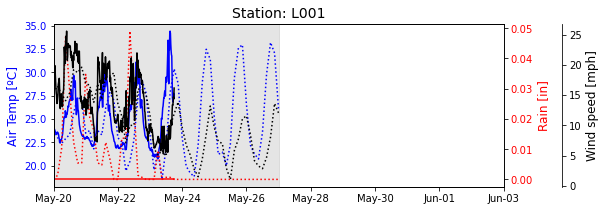

In [61]:
# fig = plt.figure(figsize=(14,4))
# host = host_subplot(111, axes_class=axisartist.Axes)
# plt.subplots_adjust(right=0.75)

fig, host = plt.subplots(figsize=(10,3))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.13))

for var, ax, c in zip(df.columns, [host, par1, par2], ['b', 'r', 'k']): 
    ax.plot(df[var], label=item, c=c)
    ax.plot(ds.time, ds[var], c=c, ls=':')
    ax.tick_params(axis='y', labelcolor=c, labelsize='medium',)
    ax.set_ylabel(var, color=c, size=12)
    
host.axvspan(ds.time[0].values, ds.time[-1].values, alpha=0.2, color='grey')
host.set_xlim(df.index[0], df.index[0]+timedelta(weeks=2))
host.set_title('Station: L001', size=14)
host.xaxis.set_major_locator(DayLocator(interval=2))
host.xaxis.set_major_formatter(DateFormatter('%b-%d'))

# host.text(ds.time[10].values, 36, 'Forecast', size=20)
# host.text(pd.to_datetime('2021-05-08'), 36, 'Observations', size=20)

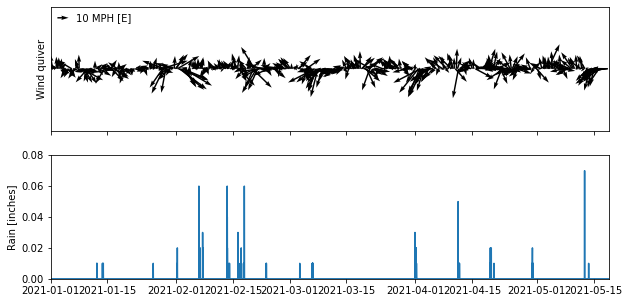

In [232]:
step=25
fig, axes = plt.subplots(2,1, figsize=(10, 5), sharex=True)
Q = axes[0].quiver(wdf.index[::step].values, np.zeros(wdf[::step].shape[0]),
            wdf.U[::step].values, wdf.V[::step].values, scale=.5e3)#units='width')
axes[0].set_xlim(wdf.index.values[0], wdf.index.values[-1])
axes[0].set_yticks([])
axes[0].set_ylabel('Wind quiver')

axes[1].plot(table_dic['R']['Val'])
axes[1].set_ylim(0,.08)
axes[1].set_ylabel('Rain [inches]')

qk = axes[0].quiverkey(Q, 0.15, 0.85, 10, '10 MPH [E]', labelpos='E',
                   coordinates='figure')

In [233]:
def plot_ts(wdf, step=25):
    fig, axes = plt.subplots(2,1, figsize=(10, 5), sharex=True)
    axes[0].quiver(wdf.index[::step].values, np.zeros(wdf[::step].shape[0]),
                wdf.U[::step].values, wdf.V[::step].values, scale=.5e3)#units='width')
    axes[0].set_xlim(wdf.index.values[0], wdf.index.values[-1])
    axes[0].set_yticks([])
    axes[0].set_ylabel('Wind quiver')

    axes[1].plot(table_dic['R']['Val'], c='k')
    axes[1].set_ylim(0,.08)
    axes[1].set_ylabel('Rain [inches]')
    qk = axes[0].quiverkey(Q, 0.15, 0.85, 10, '10 MPH', labelpos='E',
                   coordinates='figure')

Text(0.5, 0.98, 'May')

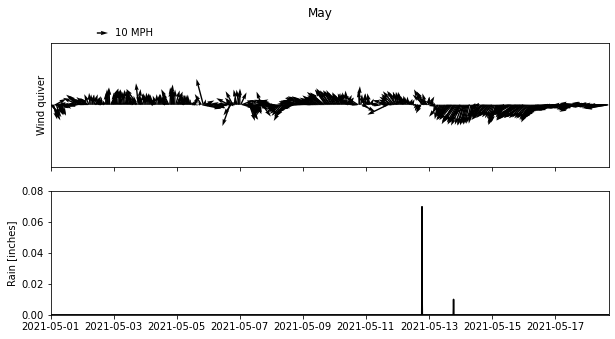

In [234]:
month = 5
plot_ts(wdf[wdf.index.month==month], step=3)
plt.suptitle(calendar.month_name[month])

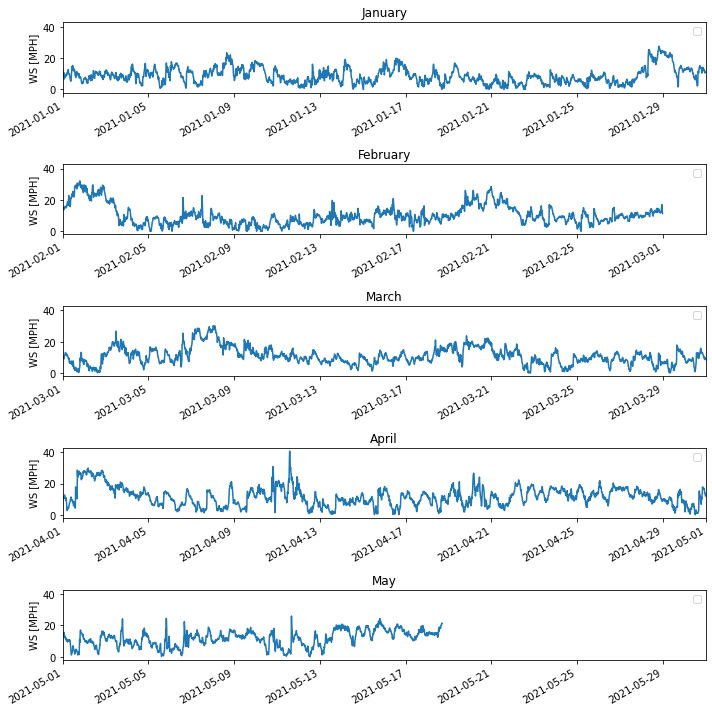

In [235]:
fig, axes = plt.subplots(5,1, figsize=(10, 10), sharey=True)
for m in np.arange(1,6):
    data = table_dic['WS'][table_dic['WS'].index.month==m]
    start = pd.to_datetime('2021-%i-01' %m)
    end = start + pd.to_timedelta('30D')
    
    data.plot(ax=axes[m-1])
    axes[m-1].set_title(calendar.month_name[m])
    axes[m-1].set_xlim(start, end)
    axes[m-1].set_xlabel('')
    axes[m-1].legend('')
    axes[m-1].set_ylabel('WS [MPH]')
    
    
fig.tight_layout()

(0.0, 180.0)

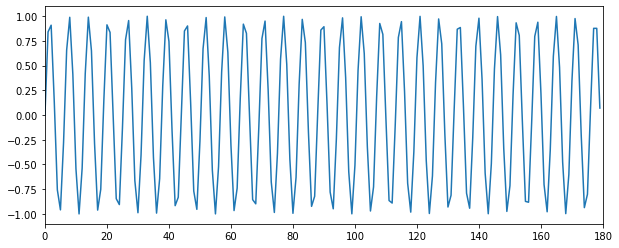

In [193]:
plt.figure(figsize=(10,4))
ang = np.arange(180)
plt.plot(ang, np.sin(ang))
plt.xlim(0,180)
# plt.plot(ang, np.cos(ang))

In [168]:
ds = xr.open_dataset('/Users/hboi/Downloads/gfs.t00z.atmf000.nc')
ds

<xarray.Dataset>
Dimensions:  (grid_xt: 3072, grid_yt: 1536, pfull: 127, phalf: 128, time: 1)
Coordinates:
  * grid_xt  (grid_xt) float64 0.0 0.1172 0.2344 0.3516 ... 359.6 359.8 359.9
  * grid_yt  (grid_yt) float64 89.91 89.79 89.68 89.56 ... -89.68 -89.79 -89.91
  * pfull    (pfull) float32 0.01278 0.02033 0.03177 ... 993.5 996.2 998.8
  * phalf    (phalf) float32 0.00999 0.01605 0.02532 ... 994.9 997.5 1e+03
  * time     (time) object 2021-05-25 00:00:00
Data variables: (12/18)
    lon      (grid_yt, grid_xt) float64 ...
    lat      (grid_yt, grid_xt) float64 ...
    cld_amt  (time, pfull, grid_yt, grid_xt) float32 ...
    clwmr    (time, pfull, grid_yt, grid_xt) float32 ...
    delz     (time, pfull, grid_yt, grid_xt) float32 ...
    dpres    (time, pfull, grid_yt, grid_xt) float32 ...
    ...       ...
    rwmr     (time, pfull, grid_yt, grid_xt) float32 ...
    snmr     (time, pfull, grid_yt, grid_xt) float32 ...
    spfh     (time, pfull, grid_yt, grid_xt) float32 ...
    tmp      (time, pfull, grid_yt, grid_xt) float32 ...
    ugrd     (time, pfull, grid_yt, grid_xt) float32 ...
    vgrd     (time, pfull, grid_yt, grid_xt) float32 ...
Attributes:
    hydrostatic:  non-hydrostatic
    ncnsto:       9
    ak:           [9.9900001e-01 1.6050000e+00 2.5320001e+00 3.9240000e+00 5....
    bk:           [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0....
    source:       FV3GFS
    grid:         gaussian
    im:           3072
    jm:           1536

In [194]:
np.arange(360)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [223]:
print(np.sin(30*np.pi/180), np.cos(30*np.pi/180))
print(np.sin(150*np.pi/180), np.cos(150*np.pi/180))

0.49999999999999994 0.8660254037844387
0.49999999999999994 -0.8660254037844387


In [210]:
output = 'WS_%s_%s.csv' % (str(table_dic['WS'].index.values[0])[:10], str(table_dic['WS'].index.values[-1])[:10])
table_dic['WS'].drop(columns='Var').rename(columns={'Val':'WS [MPH]'}).to_csv(output)

In [215]:
var = 'R'
units = {'AT':'ºC', 'RH':'%', 'RT':r'MICROMOLE/m^2/s',
         'R':'in', 'WD':'degrees clockwise', 'WS':'MPH'}

output = '%s_%s_%s.csv' % (var, str(table_dic['WS'].index.values[0])[:10], str(table_dic['WS'].index.values[-1])[:10])
table_dic[var].drop(columns='Var').rename(columns={'Val':'%s [%s]' % (var, units[var])}).to_csv(output)

In [229]:
theta = 270
x =  1 * np.cos(theta*np.pi/180 + np.pi/2)
y =  - 1 * np.sin(theta*np.pi/180 + np.pi/2)
print(x, y)

1.0 2.4492935982947064e-16


In [272]:
def plot_qts(wdf, step=25, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        
    ax.quiver(wdf.index[::step].values, np.zeros(wdf[::step].shape[0]),
              wdf.U[::step].values, wdf.V[::step].values,
               units='y',
               scale_units='y',
               scale = 1,
               headlength=1,
               headaxislength=1,
               width=0.1,
               alpha=0.8
             )
#     ax.set_yticks([])
#     ax.set_ylabel(r'N $\uparrow$', rotation=0, labelpad=10)
    ax.plot()
    ax.set_ylim(-30,30)
    qk = ax.quiverkey(Q, 0.15, 0.85, 10, '10 MPH', labelpos='E',
                   coordinates='figure')

Text(0.5, 1.0, 'May')

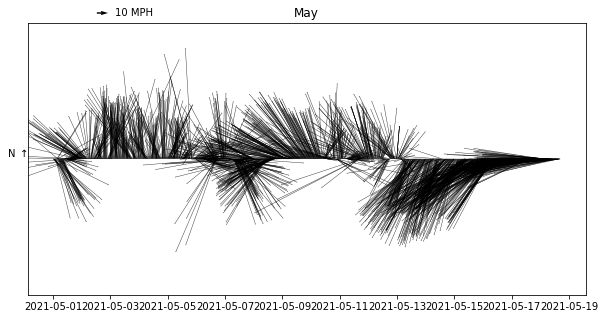

In [273]:
month = 5
plot_qts(wdf[wdf.index.month==month], step=1)
plt.title(calendar.month_name[month])

In [243]:
from math import sin, cos

In [ ]:
var_key = {
            'IX837':{'name':'AIRT', 'units': 'Degrees Celsius'},
            'IX841':{'name':'HUMI', 'units': 'Percent'},
            'IX843':{'name':'RADP', 'units': 'MICROMOLE/m^2/s'},
            'IX844':{'name':'RADT', 'units': 'kW/m^2'},
            'IX845':{'name':'RAIN', 'units': 'Inches'},
            'IX846':{'name':'STG', 'units': 't NGVD29'},
            'IX847':{'name':'WNDS', 'units': 'MPH'},
            'J0942':{'name':'BARO', 'units': 'mm Mercury'},
            'KV264':{'name':'WNVD', 'units': 'DEGREES CLOCKWI'},
            }

In [273]:
df = get_dbhydro()
df

,Air Temp [$^o$C],Rain [in],Wind speed [mph]
Date,,,
2021-05-18 00:00:00,22.95,0.0,11.27
2021-05-18 00:15:00,22.86,0.0,10.53
2021-05-18 00:30:00,22.67,0.0,9.52
2021-05-18 00:45:00,22.72,0.0,10.89
2021-05-18 01:00:00,22.83,0.0,11.13
...,...,...,...
2021-05-23 17:00:00,26.99,0.0,13.30
2021-05-23 17:15:00,26.81,0.0,13.77
2021-05-23 17:30:00,27.20,0.0,14.70


In [2]:
path = 'filter_gfs_0p25_1hr.pl?file=gfs.t00z.pgrb2.0p25.f000&var_APCP=on&var_TMP=on&var_UGRD=on&var_VGRD=on&leftlon=-81&rightlon=-80&toplat=27&bottomlat=28&dir=%2Fgfs.20210525%2F00%2Fatmos'
ds = xr.open_dataset(path, engine='cfgrib')
ds

DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
    filter_by_keys={'typeOfLevel': 'isobaricInPa'}
    filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
    filter_by_keys={'typeOfLevel': 'surface'}
    filter_by_keys={'typeOfLevel': 'heightAboveGround'}
    filter_by_keys={'typeOfLevel': 'tropopause'}
    filter_by_keys={'typeOfLevel': 'maxWind'}
    filter_by_keys={'typeOfLevel': 'heightAboveSea'}
    filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
    filter_by_keys={'typeOfLevel': 'sigma'}
    filter_by_keys={'typeOfLevel': 'potentialVorticity'}

In [3]:
import cfgrib

In [10]:
path = 'filter_gfs_0p25.pl?file=gfs.t18z.pgrb2.0p25.f000&var_PRATE=on&leftlon=0&rightlon=360&toplat=90&bottomlat=-90&dir=%2Fgfs.20210525%2F18%2Fatmos'
ds = cfgrib.open_datasets(path)

Ignoring index file '/Users/hboi/Projects/dbhydro/filter_gfs_0p25.pl?file=gfs.t18z.pgrb2.0p25.f000&var_PRATE=on&leftlon=0&rightlon=360&toplat=90&bottomlat=-90&dir=%2Fgfs.20210525%2F18%2Fatmos.923a8.idx' incompatible with GRIB file


In [11]:
ds

[<xarray.Dataset>
 Dimensions:     (latitude: 721, longitude: 1440)
 Coordinates:
     time        datetime64[ns] 2021-05-25T18:00:00
     step        timedelta64[ns] 00:00:00
     surface     float64 0.0
   * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
   * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
     valid_time  datetime64[ns] ...
 Data variables:
     prate       (latitude, longitude) float32 ...
 Attributes:
     GRIB_edition:            2
     GRIB_centre:             kwbc
     GRIB_centreDescription:  US National Weather Service - NCEP 
     GRIB_subCentre:          0
     Conventions:             CF-1.7
     institution:             US National Weather Service - NCEP ]